<a href="https://colab.research.google.com/github/drhammed/P_Machine_Learning_projects/blob/main/Hammed_Akande_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework
Create an RL that can balance pole in the CartPole game for 400 frames.

In [1]:
# !pip install gym==0.23.0
# !pip install pygame==2.1.3
# !pip install tensorflow==2.15.0
# !pip install tf-agents==0.19.0
# !pip install pyvirtualdisplay
#!pip uninstall -y tensorflow keras tf-agents
#!pip install tensorflow keras tf-agents
#!pip install --upgrade tensorflow tf-agents keras
#!pip install tf-agents

In [12]:
import tensorflow as tf
from tf_agents.environments import suite_gym
from tf_agents.environments.wrappers import TimeLimit
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.networks import actor_distribution_network, value_network
from tf_agents.agents.ppo import ppo_agent
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.policies import random_tf_policy, py_tf_eager_policy
from tf_agents.drivers import dynamic_step_driver
from tf_agents.metrics import tf_metrics
from tf_agents.utils import common
from tf_agents.eval import metric_utils
import tensorflow.keras as keras


In [ ]:
!apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
!pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]

In [29]:
# CartPole environment
env = suite_gym.load('CartPole-v0')
env = TimeLimit(env, duration=400)

# TFPyEnvironment
tf_env = TFPyEnvironment(env)

# Set hyperparameters
learning_rate = 1e-3
replay_buffer_max_length = 100000
batch_size = 64
train_step_counter = tf.Variable(0)

# Create actor and value networks
actor_net = actor_distribution_network.ActorDistributionNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=(100,)
)

value_net = value_network.ValueNetwork(
    tf_env.observation_spec(),
    fc_layer_params=(100,)
)

# Create PPO Agent
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
agent = ppo_agent.PPOAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    actor_net=actor_net,
    value_net=value_net,
    optimizer=optimizer,
    train_step_counter=train_step_counter,
    num_epochs=10,
    use_gae=True,
    lambda_value=0.95,
    discount_factor=0.99,
    entropy_regularization=0.01,
    importance_ratio_clipping=0.2,
    use_td_lambda_return=True,
    gradient_clipping=0.5,
    value_pred_loss_coef=0.5,
)
agent.initialize()

# Create replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length
)

# Collect initial data using a random policy compatible with the agent's policy
initial_collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
    agent.collect_policy, use_tf_function=True
)

# Driver to collect initial data
initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=1000  # Collect 1000 steps initially
)

# Run the initial data collection
final_time_step, final_policy_state = initial_collect_driver.run()

# Prepare the dataset for training
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2,
    single_deterministic_pass=False
).prefetch(3)

# Create an iterator for the dataset
iterator = iter(dataset)

# Training the agent
num_iterations = 10000
collect_steps_per_iteration = 1
log_interval = 200
eval_interval = 1000
num_eval_episodes = 10

# Metrics and Evaluation
train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

eval_policy = agent.policy
collect_policy = agent.collect_policy

# Create driver for data collection
collect_driver = dynamic_step_driver.DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer.add_batch] + train_metrics,
    num_steps=collect_steps_per_iteration
)

# Reset the environment
tf_env.reset()

# Define metrics
average_return_metric = tf_metrics.AverageReturnMetric()
average_episode_length_metric = tf_metrics.AverageEpisodeLengthMetric()

# Define the evaluation function
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    total_length = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        episode_length = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            episode_length += 1

        total_return += episode_return
        total_length += episode_length

    avg_return = total_return / num_episodes
    avg_length = total_length / num_episodes
    return avg_return.numpy()[0], avg_length

# Define a training step function with tf.function to avoid retracing
@tf.function
def train_step():
    # Collect a few steps and save to the replay buffer.
    collect_driver.run()

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    return agent.train(experience)

# Moving average to smooth metrics
def moving_average(values, window_size):
    return np.convolve(values, np.ones(window_size)/window_size, mode='valid')

# Lists to store the returns and episode lengths for plotting
returns = []
episode_lengths = []

# Training loop
for iteration in range(num_iterations):
    # Perform a training step
    train_loss = train_step().loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print(f'step = {step}: loss = {train_loss}')

    if step % eval_interval == 0:
        avg_return, avg_length = compute_avg_return(tf_env, agent.policy, num_eval_episodes)
        returns.append(avg_return)
        episode_lengths.append(avg_length)
        print(f'step = {step}: Average Return = {avg_return}, Average Episode Length = {avg_length}')



step = 200: loss = 4.959449291229248
step = 400: loss = 16.81336784362793
step = 600: loss = 22.278709411621094
step = 800: loss = 15.416905403137207
step = 1000: loss = 68.25819396972656
step = 1000: Average Return = 23.5, Average Episode Length = 23.5
step = 1200: loss = 78.77281951904297
step = 1400: loss = 189.83641052246094
step = 1600: loss = 190.39930725097656
step = 1800: loss = 299.8953857421875
step = 2000: loss = 219.10275268554688
step = 2000: Average Return = 29.600000381469727, Average Episode Length = 29.6
step = 2200: loss = 164.4349365234375
step = 2400: loss = 2.907965898513794
step = 2600: loss = 106.91413116455078
step = 2800: loss = 1.091949224472046
step = 3000: loss = 326.2825927734375
step = 3000: Average Return = 18.0, Average Episode Length = 18.0
step = 3200: loss = 2.8984274864196777
step = 3400: loss = 245.0868682861328
step = 3600: loss = 40.36767578125
step = 3800: loss = 37.06068801879883
step = 4000: loss = 695.9435424804688
step = 4000: Average Return 

In [30]:
# Calculate the smoothed returns and episode lengths
smoothed_returns = moving_average(returns, window_size=5)
smoothed_episode_lengths = moving_average(episode_lengths, window_size=5)

print("Smoothed Average Return:", smoothed_returns)
print("Smoothed Average Episode Length:", smoothed_episode_lengths)


Smoothed Average Return: [20.64000015 24.18000031 23.94000015 25.46000023 30.20000038 35.44000015
 35.08000031 36.64000053 40.10000076 39.60000076 42.98000107 42.76000061
 46.26000061 46.22000046 48.2        46.25999985 48.3        48.77999954
 54.1        55.5        54.44000015 55.98000031 56.88000031 50.5
 46.62000046 51.70000076 53.8        58.98000031 65.18000031 66.61999969
 64.43999939 62.9        60.16000061 59.98000031 65.72000122 66.06000137
 61.94000168 55.96000137 48.82000122 41.86000061 40.52000046 39.88000031
 43.14000015 45.4        42.84000015 39.36000023 45.15999947 42.59999962
 45.03999977 46.81999931 46.95999908 43.17999954 41.29999924 37.63999939
 37.7        38.32000046 37.90000076 39.64000092 39.48000107 44.04000092
 44.62000046 46.8        58.09999924 60.03999939 57.33999939 58.05999985
 57.55999985 44.36000061 41.52000046 38.8        39.1        44.31999969
 46.99999924 48.25999908 54.09999924 53.57999878 47.11999969 44.45999985
 47.64000015 43.72000046 47.06000

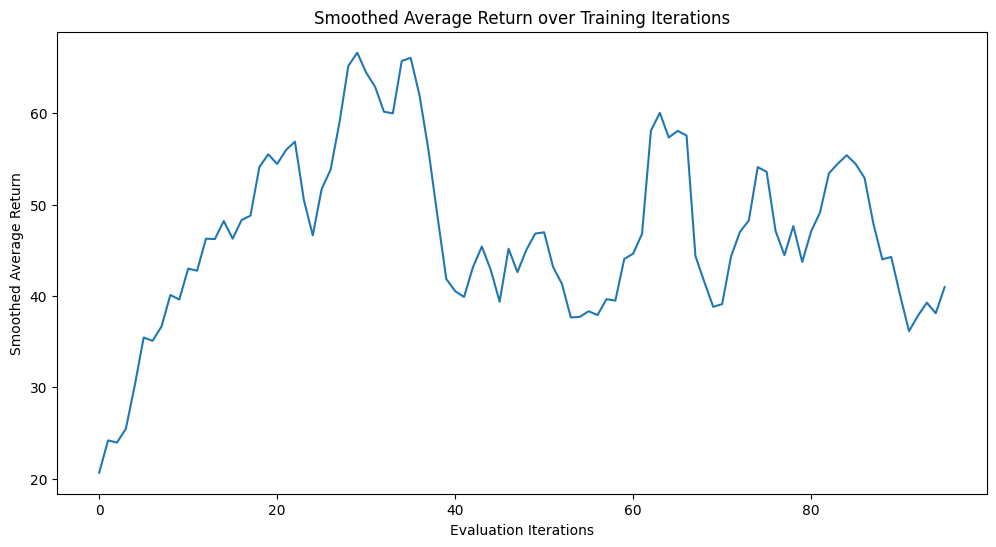

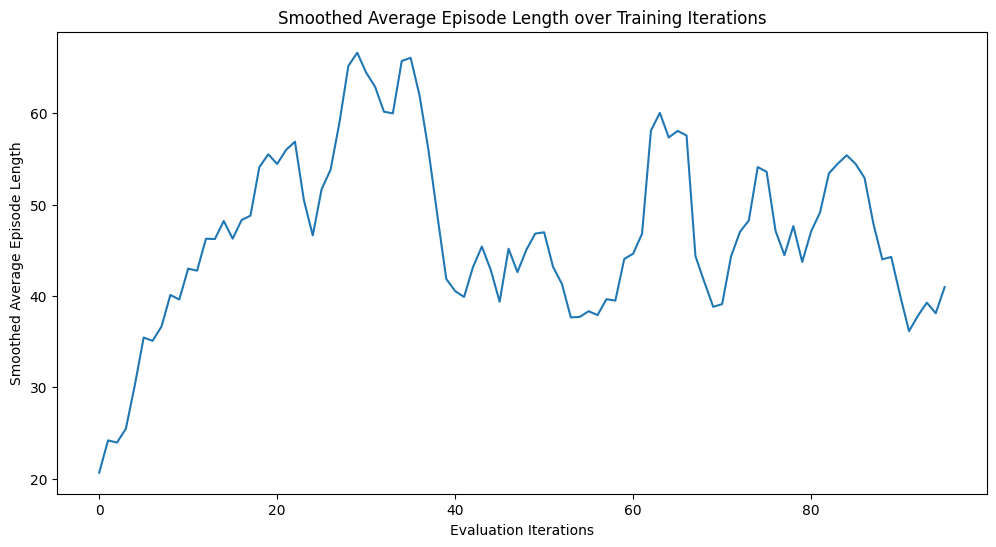

In [32]:
# Plot the smoothed average return
plt.figure(figsize=(12, 6))
plt.plot(smoothed_returns)
plt.xlabel('Evaluation Iterations')
plt.ylabel('Smoothed Average Return')
plt.title('Smoothed Average Return over Training Iterations')
plt.show()

# Plot the smoothed average episode length
plt.figure(figsize=(12, 6))
plt.plot(smoothed_episode_lengths)
plt.xlabel('Evaluation Iterations')
plt.ylabel('Smoothed Average Episode Length')
plt.title('Smoothed Average Episode Length over Training Iterations')
plt.show()


In [31]:
# Test the trained agent
frames = []
time_step = tf_env.reset()
while not time_step.is_last():
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))
    action_step = eval_policy.action(time_step)
    time_step = tf_env.step(action_step.action)


In [33]:
# Plot the animation
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=20):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [34]:
plot_animation(frames)